https://jkolbert2.github.io/

# Milestone 1

Recently the Streaming market has seen a sudden, stark increase in competition. New companies seem to be entering the market every day, challenging the current champion, Netflix. Each company has its own advantages and disadvantages, and for the purpose of this project, I am going to focus on two companies in particular: Netflix and Disney. Disney recnetly launched their own streaming platfomr Disney+. I am curious to see how a entertainment conglomerate such as Disney's content compares with that of the newer Netflix. 

Specifically, I want to use the IMDB api available at http://www.omdbapi.com/, to compare these two companies average ratings for their movies and tv shows. I further hope to use specific metrics for each movie, genre, for example, to see if I can predict how a movie will score based on other metrics. For example, were horror movies produced by disney recieved better by audiences in the past than today? Or, can I predict how well a horror movie did, based on the year it was published? Other questions include: does netflix thrive in producing well liked content in any specic Genre? is there a correlation between the year netflix produced a move and how well audiences recieved it?

Ultimatly, I hope to guide the reader of my tutorial through each step of my analysis. I would also like to reveal any insights within the data that may suggest one streaming service will be more liked by viewers other in the long term, although there are obvioulsy several exterior factors to this. 

My first step for this project is to create a histogram for the mean IMDB scores for either companies streaming service. Disney+ specific shows have been announced at (https://www.theverge.com/2019/10/14/20913417/disney-plus-launch-lineup-marvel-star-wars-pixar-tv-shows-movies-simpsons-national-geographic), and netflix has a wikipedia page about its orignal movie productions, which I will likely start with before incorporating tv information. 


Make sure before attempting this that you have install html5lib and lxml. you should also go to (http://www.omdbapi.com/apikey.aspx) and generate an API key. Each API key only gets 1000 (free) requests to the database per day, so you may need to replace the API key paramater with you own API key in various URLs throughout this project. (make sure you remember to activate your key, as the instrutions on the omdb website indicate)

you also need to make sure you have decent internet connection - poor connection may result in a pull failing wiht a timeout.

# Milestone 2

## Part 1: Data Collection From http://www.omdbapi.com/

### Data Collection 1: Netflix

To collect ratings from Netflix we are going to grab title names from the Wikipedia page of Netflix Origninal films (https://en.wikipedia.org/wiki/List_of_original_films_distributed_by_Netflix), Convert them into the appropratie URLs for OMDB, and then grab the necessary infomration out of the JSON unit that OMDB will return to us. 

The First step, grabbing titles from wikipedia, is seen below

In [126]:
# Step 0: necessary imports
import urllib.request
import bs4 as bs
import pandas as pd
import numpy as np
import requests
import xml.etree.ElementTree as ET
from io import StringIO
import html5lib

#Step 1: Pull page of original Netlix movies from wikipedia

netflix_list = "https://en.wikipedia.org/wiki/List_of_original_films_distributed_by_Netflix"
request_netflix = requests.get(netflix_list)
source_netflix = urllib.request.urlopen(netflix_list).read()
soup = bs.BeautifulSoup(source_netflix, 'html.parser')

#Step 2: isolate the tables from this page
table = soup.find_all('table')

#step 3: remove additional excess information
table = table[:-22]

#step 4: create df to store netflix original movies
netflix_films_df = pd.DataFrame()

#step 5: iterate over every table, parse its html, and add each table as a DF to the netflix films df
for table in table:
    pd_table = pd.read_html(table.prettify(), header = 0)
    temp_df = pd_table[0]
    netflix_films_df = netflix_films_df.append(temp_df)
    
#we want to see all titles, so
pd.set_option('display.max_rows', 100) #we want to see a lot of entries 


#step 6: drop any duplicate wikipedia entries
netflix_films_df = netflix_films_df.drop_duplicates(subset="Title", keep='first')

#step7: display df
netflix_films_df

,Genre,Language,Languages,Length,Netflix exclusive region,Premiere,Runtime,Title
0,War / drama,English/Twi,NaN,"2 hours, 16 min.",NaN,"October 16, 2015",NaN,Beasts of No Nation
1,Action,English,NaN,"1 hour, 43 min.",NaN,"February 26, 2016",NaN,"Crouching Tiger, Hidden Dragon: Sword of Destiny"
2,Comedy-drama,English,NaN,"1 hour, 37 min.",NaN,"June 24, 2016",NaN,The Fundamentals of Caring
3,Thriller,English,NaN,"1 hour, 40 min.",NaN,"July 15, 2016",NaN,Rebirth
4,Comedy-drama,English,NaN,"1 hour, 51 min.",NaN,"July 29, 2016",NaN,Tallulah
5,Drama,English,NaN,"1 hour, 32 min.",NaN,"August 26, 2016",NaN,XOXO
6,Science fiction / Thriller,English,NaN,"1 hour, 28 min.",NaN,"September 16, 2016",NaN,ARQ
7,War film,English,NaN,"1 hour, 48 min.",NaN,"October 7, 2016",NaN,The Siege of Jadotville
8,Horror,English,NaN,"1 hour, 29 min.",NaN,"October 28, 2016",NaN,I Am the Pretty Thing That Lives in the House
9,Drama,Spanish,NaN,"1 hour, 16 min.",NaN,"October 28, 2016",NaN,7 años


The next part is to push these titles to the OMDB API, and find the correlating JSON data item for each movie.

In [127]:
#step 1: create df to hold new ratings df info
netflix_ratings_df = pd.DataFrame()

errors = 0
#step 2: iterate through each row in netflix_df grabbing title. from there
for row in netflix_films_df['Title']:
    try:
        row_search = urllib.parse.quote(row)
        #convert each row to a ombdapi URL. notcie the %s, which is a placeholder for the approrpriate movie
        #it may be worth it to add in a placeholder for the API key as well. 
        url = ("http://www.omdbapi.com/?t=%s&r=json&apikey=742f26a8" % row_search)
        request = requests.get(url)
        source = urllib.request.urlopen(url).read()
        source = source.decode()
        d = {'Title' : row, 'JSON_DATA' : source}
        df = pd.DataFrame(data=d, index=[0])
        netflix_ratings_df = netflix_ratings_df.append(df)
    #test for any errors in retrieving dtaa
    except:
        print("Error with %s" % row)
        print(url)
        errors += 1

In [128]:
print("%s error in getting json data" % errors)
netflix_ratings_df

0 error in getting json data


,Title,JSON_DATA
0,Beasts of No Nation,"{""Title"":""Beasts of No Nation"",""Year"":""2015"",""..."
0,"Crouching Tiger, Hidden Dragon: Sword of Destiny","{""Title"":""Crouching Tiger, Hidden Dragon: Swor..."
0,The Fundamentals of Caring,"{""Title"":""The Fundamentals of Caring"",""Year"":""..."
0,Rebirth,"{""Title"":""Rebirth"",""Year"":""2016"",""Rated"":""TV-M..."
0,Tallulah,"{""Title"":""Tallulah"",""Year"":""2016"",""Rated"":""N/A..."
0,XOXO,"{""Title"":""XOXO"",""Year"":""2016"",""Rated"":""TV-MA"",..."
0,ARQ,"{""Title"":""ARQ"",""Year"":""2016"",""Rated"":""TV-MA"",""..."
0,The Siege of Jadotville,"{""Title"":""The Siege of Jadotville"",""Year"":""201..."
0,I Am the Pretty Thing That Lives in the House,"{""Title"":""I Am the Pretty Thing That Lives in ..."
0,7 años,"{""Title"":""7 Años"",""Year"":""2016"",""Rated"":""N/A"",..."


You may notice how some of these say "response:false, error: movie not found!"
lets isolate these movies and see if we can find a pattern.

In [129]:
error_netflix_movies = netflix_ratings_df[netflix_ratings_df['JSON_DATA'] == "{\"Response\":\"False\",\"Error\":\"Movie not found!\"}"]

#we will also remove these from the current dataframe, so we can add in the fixes later
netflix_ratings_df = netflix_ratings_df[netflix_ratings_df['JSON_DATA'] != "{\"Response\":\"False\",\"Error\":\"Movie not found!\"}"]

error_netflix_movies


,Title,JSON_DATA
0,The Irishman [2],"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Dead Kids [5],"{""Response"":""False"",""Error"":""Movie not found!""}"
0,The Paramedic [6],"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Brij Mohan Amar Rahe,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,5 Star Christmas,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,House Arrest [8],"{""Response"":""False"",""Error"":""Movie not found!""}"
0,The Knight Before Christmas [10],"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Holiday Rush [12],"{""Response"":""False"",""Error"":""Movie not found!""}"
0,A Christmas Prince: The Royal Baby [13],"{""Response"":""False"",""Error"":""Movie not found!""}"
0,To All the Boys: P.S. I Still Love You [14],"{""Response"":""False"",""Error"":""Movie not found!""}"


Some of these appear to be still in development. Some however,appear to be creating an error because of wikipedia citaitons! lets edit those out

In [130]:
error_netflix_movies['Title'] = error_netflix_movies['Title'].str.split('\[').str[0]
error_netflix_movies

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Title,JSON_DATA
0,The Irishman,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Dead Kids,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,The Paramedic,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Brij Mohan Amar Rahe,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,5 Star Christmas,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,House Arrest,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,The Knight Before Christmas,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Holiday Rush,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,A Christmas Prince: The Royal Baby,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,To All the Boys: P.S. I Still Love You,"{""Response"":""False"",""Error"":""Movie not found!""}"


Now lets run these back through our previous steps to push it to OMDB, and reject any that are in development.

In [132]:
fixed_netflix_errors_df = pd.DataFrame()
for row in error_netflix_movies['Title']:
    try:
        row_search = urllib.parse.quote(row)
        url = ("http://www.omdbapi.com/?t=%s&r=json&apikey=a7e31369" % row_search)
        request = requests.get(url)
        source = urllib.request.urlopen(url).read()
        source = source.decode()
        d = {'Title' : row, 'JSON_DATA' : source}
        df = pd.DataFrame(data=d, index=[0])
        fixed_netflix_errors_df = fixed_netflix_errors_df.append(df)
    #test for any errors in retrieving dtaa
    except:
        print("Error with %s" % row)
        print(url)
        errors += 1


In [133]:
#now we can assume that any more not found movies are likely in development, and we should drop them.
fixed_netflix_errors_df = fixed_netflix_errors_df[fixed_netflix_errors_df['JSON_DATA'] != "{\"Response\":\"False\",\"Error\":\"Movie not found!\"}"]
fixed_netflix_errors_df

,Title,JSON_DATA
0,The Irishman,"{""Title"":""The Irishman"",""Year"":""2019"",""Rated"":..."
0,Dead Kids,"{""Title"":""Dead Kids"",""Year"":""2019"",""Rated"":""N/..."
0,The Paramedic,"{""Title"":""The Paramedic"",""Year"":""1982"",""Rated""..."
0,House Arrest,"{""Title"":""House Arrest"",""Year"":""1996"",""Rated"":..."
0,The Knight Before Christmas,"{""Title"":""The Knight Before Christmas"",""Year"":..."
0,Holiday Rush,"{""Title"":""Holiday Rush"",""Year"":""2019"",""Rated"":..."
0,A Christmas Prince: The Royal Baby,"{""Title"":""A Christmas Prince: The Royal Baby"",..."
0,"Bikram: Yogi, Guru, Predator","{""Title"":""Bikram: Yogi, Guru, Predator"",""Year""..."
0,First Ladies,"{""Title"":""First Ladies"",""Year"":""2012"",""Rated"":..."
0,Sérgio,"{""Title"":""Sergio Herman: Fucking Perfect"",""Yea..."


Now we just add these fixed values back to the original dataframe

In [134]:
netflix_ratings_df = netflix_ratings_df.append(fixed_netflix_errors_df)

#drop any additional values that returned multiple IMDB pages. Negligent amount and thus easy to dispose of
netflix_ratings_df = netflix_ratings_df[netflix_ratings_df['JSON_DATA'] != "{\"Response\":\"False\",\"Error\":\"Subquery returned more than 1 value. This is not permitted when the subquery follows =, !=, <, <= , >, >= or when the subquery is used as an expression.\"}"]

netflix_ratings_df


,Title,JSON_DATA
0,Beasts of No Nation,"{""Title"":""Beasts of No Nation"",""Year"":""2015"",""..."
0,"Crouching Tiger, Hidden Dragon: Sword of Destiny","{""Title"":""Crouching Tiger, Hidden Dragon: Swor..."
0,The Fundamentals of Caring,"{""Title"":""The Fundamentals of Caring"",""Year"":""..."
0,Rebirth,"{""Title"":""Rebirth"",""Year"":""2016"",""Rated"":""TV-M..."
0,Tallulah,"{""Title"":""Tallulah"",""Year"":""2016"",""Rated"":""N/A..."
0,XOXO,"{""Title"":""XOXO"",""Year"":""2016"",""Rated"":""TV-MA"",..."
0,ARQ,"{""Title"":""ARQ"",""Year"":""2016"",""Rated"":""TV-MA"",""..."
0,The Siege of Jadotville,"{""Title"":""The Siege of Jadotville"",""Year"":""201..."
0,I Am the Pretty Thing That Lives in the House,"{""Title"":""I Am the Pretty Thing That Lives in ..."
0,7 años,"{""Title"":""7 Años"",""Year"":""2016"",""Rated"":""N/A"",..."


Now that we have a dataframe with each row representing one movie and its associated JSON data, we can parse this JSON data for interesting data. Specifically, we are looking for: Rating data, Release Year, and Genre

In [135]:

netflix_ratings_df['Year'] = netflix_ratings_df['JSON_DATA'].apply(lambda x: x.split("Year")[1][3:7])
netflix_ratings_df['Rating'] = netflix_ratings_df['JSON_DATA'].apply(lambda x: x.split("imdbRating")[1][3:6])
netflix_ratings_df['Genre'] = netflix_ratings_df['JSON_DATA'].apply(lambda x: x.split("Genre")[1][3:6])
netflix_ratings_df['Genre'].unique()

#N/A will automatically be converted to np.nan
netflix_ratings_df["Genre"] = netflix_ratings_df["Genre"].map({
       "Dra": "Drama",
       "Cri": "Crime",
       "Act": "Action",
       "Com": "Comedy",
       "Thr": "Thriller",
       "Hor": "Horror",
       "Bio": "Biography",
       "Ani": "Animation",
       "Mys": "Myster",
       "Sci": "Sci-Fi",
       "Sho": "Short",
       "Adv": "Adventure",
       "Rom": "Romance",
       "Doc": "Documentary",
       "Mus": "Music",
       "Rea": "Reality",
       "Fam": "Family",
       "Fan": "Fantasy",
       "Adu": "Adult"
})
#for now, we will drop the JSON data column. If in the future, we decide we want more data, we can always load it in again

netflix_ratings_df = netflix_ratings_df.drop(['JSON_DATA'], axis=1)
netflix_ratings_df


,Title,Year,Rating,Genre
0,Beasts of No Nation,2015,7.8,Drama
0,"Crouching Tiger, Hidden Dragon: Sword of Destiny",2016,6.1,Action
0,The Fundamentals of Caring,2016,7.3,Comedy
0,Rebirth,2016,5.0,Thriller
0,Tallulah,2016,6.7,Comedy
0,XOXO,2016,5.3,Drama
0,ARQ,2016,6.4,Action
0,The Siege of Jadotville,2016,7.3,Action
0,I Am the Pretty Thing That Lives in the House,2016,4.5,Horror
0,7 años,2016,6.8,Drama


Now we are going to find a Distibution of IMDB ratings for netflix movies!

Text(6, 150, 'Netflix Original Movies')

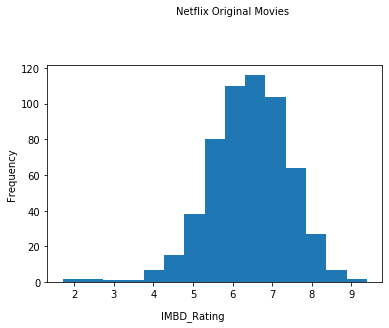

In [136]:
#step 1: convert necessary dtypes, and replace any missing values in ratings column

netflix_ratings_df['Rating'] = netflix_ratings_df['Rating'].replace(['N/A'], np.nan)
netflix_ratings_df['Rating'] = netflix_ratings_df['Rating'].astype(float)

#step 2: plot it!
netflix_ratings_hist = netflix_ratings_df['Rating'].plot.hist(bins = 15, by="Rating")

#stpe 3: edit labels
netflix_ratings_hist.text(5, -20, 'IMBD_Rating', ha='center')
netflix_ratings_hist.text(6, 150, 'Netflix Original Movies', ha='center')

### Data Collection 2: Disney+

To aggregate information for disney, we are going to grab the list of every title that is currently available on disney+ from this verge article (https://www.theverge.com/2019/10/14/20913417/disney-plus-launch-lineup-marvel-star-wars-pixar-tv-shows-movies-simpsons-national-geographic). We will then, much like we did for Netflix, convert these movies to the approriate URL for OMDB, and then grab the information we want out of the returned JSON unit.

In [137]:
#step 0: imports
import urllib.request
import bs4 as bs
import pandas as pd
import numpy as np
import requests
import xml.etree.ElementTree as ET
from io import StringIO

#step 1: Necessary Setting adjustments
pd.set_option('display.max_rows', 100) #we want to see a lot of rows
apikey = 'b9b7add3' #apikey to access omdb. 

#step 2: pull page from theverge
disney_list = "https://www.theverge.com/2019/10/14/20913417/disney-plus-launch-lineup-marvel-star-wars-pixar-tv-shows-movies-simpsons-national-geographic"
request_disney = requests.get(disney_list)
source_disney = urllib.request.urlopen(disney_list).read()
soup = bs.BeautifulSoup(source_disney, 'html.parser')

#step 3: isolate title lines in HTML 
list2 = soup.find_all('em')
list_true = list2[20:] #first 20 characters are explanatory, here we skip over htese

#step 4: create series out of title list
disney_films = pd.Series(list_true)

#step 5: turn it into a dataframe
disney_films_df = pd.DataFrame(disney_films, columns=['Title'])

#step 6: convert all titles to strings only
disney_films_df['Title'] =  disney_films_df['Title'].apply(lambda x: str(x))

#step 7: replace <em> tags with. '' so we isolatetitles
disney_films_df['Title'] =  disney_films_df['Title'].apply(lambda x: x.replace('<em>','').replace('</em>',''))

#Step 8: filter out extra data
disney_films_df = disney_films_df[:-5] #last 5 rows are explanatory/irrelevnt <em> tags. remove mannually

#step 9: display
disney_films_df


,Title
0,Swiss Family Robinson
1,Miracle on 34th Street
2,Treasure Island
3,The Story of Robin Hood and His Merrie Men
4,The Living Desert
5,The Vanishing Prairie
6,"20,000 Leagues Under the Sea"
7,"Davy Crockett, King of the Wild Frontier"
8,The African Lion
9,Davy Crockett and the River Pirates


Now that we have a list of titles, we can push them to the OMBD API to get a JSON object containing relevant infomration.

In [138]:
#current api key: ed54ed5a
#if you get the "failed at url" message, create a new api key,  activate it, and paste it into the line ("http://www.omdbapi.com/?t=%s&r=json&apikey=PASTEHERE)"


from urllib.parse import urlencode
problematic_titles = []
returned_null = []
errors = 0
apikey="ed54ed5a"
disney_films_df_best = pd.DataFrame()
for row in disney_films_df['Title']:
    try:
        row_search = urllib.parse.quote(row)
        url = ("http://www.omdbapi.com/?t=%s&r=json&apikey=ed54ed5a" % row_search)
        request = requests.get(url)
        source = urllib.request.urlopen(url).read()
        source = source.decode()
        d = {'Title' : row, 'JSON_DATA' : source}
        df = pd.DataFrame(data=d, index=[0])
        disney_films_df_best = disney_films_df_best.append(df)
    except:
        print("failed at %s" % url)
disney_films_df_best


failed at http://www.omdbapi.com/?t=Marvel%20Comics%20Spider-Man%20-%20Series&r=json&apikey=ed54ed5a


,Title,JSON_DATA
0,Swiss Family Robinson,"{""Title"":""Swiss Family Robinson"",""Year"":""1960""..."
0,Miracle on 34th Street,"{""Title"":""Miracle on 34th Street"",""Year"":""1947..."
0,Treasure Island,"{""Title"":""Treasure Island"",""Year"":""1950"",""Rate..."
0,The Story of Robin Hood and His Merrie Men,"{""Title"":""The Story of Robin Hood and His Merr..."
0,The Living Desert,"{""Title"":""The Living Desert"",""Year"":""1953"",""Ra..."
0,The Vanishing Prairie,"{""Title"":""The Vanishing Prairie"",""Year"":""1954""..."
0,"20,000 Leagues Under the Sea","{""Title"":""20,000 Leagues Under the Sea"",""Year""..."
0,"Davy Crockett, King of the Wild Frontier","{""Title"":""Davy Crockett: King of the Wild Fron..."
0,The African Lion,"{""Title"":""The African Lion"",""Year"":""1955"",""Rat..."
0,Davy Crockett and the River Pirates,"{""Title"":""Davy Crockett and the River Pirates""..."


In [110]:
#drop duplicates and measure and display table
disney_films_df_best = disney_films_df_best.drop_duplicates(subset="Title", keep='first')
disney_films_df_best.count()
disney_films_df_best

,Title,JSON_DATA
0,Swiss Family Robinson,"{""Title"":""Swiss Family Robinson"",""Year"":""1960""..."
0,Miracle on 34th Street,"{""Title"":""Miracle on 34th Street"",""Year"":""1947..."
0,Treasure Island,"{""Title"":""Treasure Island"",""Year"":""1950"",""Rate..."
0,The Story of Robin Hood and His Merrie Men,"{""Title"":""The Story of Robin Hood and His Merr..."
0,The Living Desert,"{""Title"":""The Living Desert"",""Year"":""1953"",""Ra..."
0,The Vanishing Prairie,"{""Title"":""The Vanishing Prairie"",""Year"":""1954""..."
0,"20,000 Leagues Under the Sea","{""Title"":""20,000 Leagues Under the Sea"",""Year""..."
0,"Davy Crockett, King of the Wild Frontier","{""Title"":""Davy Crockett: King of the Wild Fron..."
0,The African Lion,"{""Title"":""The African Lion"",""Year"":""1955"",""Rat..."
0,Davy Crockett and the River Pirates,"{""Title"":""Davy Crockett and the River Pirates""..."


Now, Let's check for errors, Like we did with netflix

In [139]:
error_checking = disney_films_df_best.copy()
disney_film_errors = error_checking[error_checking['JSON_DATA'] == "{\"Response\":\"False\",\"Error\":\"Movie not found!\"}"]

disney_film_errors

,Title,JSON_DATA
0,Darby O’Gill and the Little People,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,"Sammy, the Way-Out Seal","{""Response"":""False"",""Error"":""Movie not found!""}"
0,Blackbeard’s Ghost (1968),"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Sultan and the Rock Star (1980),"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Mr. Boogedy (1986),"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Fuzzbucket (1986),"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Turner &amp; Hooch,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Three Men and a Little Lady,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,I’ll Be Home for Christmas,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Don’t Look Under the Bed,"{""Response"":""False"",""Error"":""Movie not found!""}"


The errors here are a bit more complicated than they were for netflix.

"teen beach movie 2", for insantce, fails because IMDB lists it as "Teen beach 2." That being said, there are still some patterns we can try to fix. 

Some movies, for instance, have the year they were released in parenthesis next to their name. in the case of blackbeard's ghost, for instance, this makes the API fail to find it. The first thing well do is thus detect and fix those parenthesis.

In [140]:
disney_film_errors['Title'] = disney_film_errors['Title'].str.split('(').str[0]
disney_film_errors

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Title,JSON_DATA
0,Darby O’Gill and the Little People,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,"Sammy, the Way-Out Seal","{""Response"":""False"",""Error"":""Movie not found!""}"
0,Blackbeard’s Ghost,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Sultan and the Rock Star,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Mr. Boogedy,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Fuzzbucket,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Turner &amp; Hooch,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Three Men and a Little Lady,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,I’ll Be Home for Christmas,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Don’t Look Under the Bed,"{""Response"":""False"",""Error"":""Movie not found!""}"


Another common issue is that some movies have a II, whereas the API expects a 2. or the movie is listed as III, wheras the API expects 3. This is also a simple fix

In [141]:
disney_film_errors['Title'] = disney_film_errors['Title'].str.replace('III', '3')
disney_film_errors['Title'] = disney_film_errors['Title'].str.replace('II', '2')
disney_film_errors

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Title,JSON_DATA
0,Darby O’Gill and the Little People,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,"Sammy, the Way-Out Seal","{""Response"":""False"",""Error"":""Movie not found!""}"
0,Blackbeard’s Ghost,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Sultan and the Rock Star,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Mr. Boogedy,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Fuzzbucket,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Turner &amp; Hooch,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Three Men and a Little Lady,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,I’ll Be Home for Christmas,"{""Response"":""False"",""Error"":""Movie not found!""}"
0,Don’t Look Under the Bed,"{""Response"":""False"",""Error"":""Movie not found!""}"


Now we can again try to find matching imdb pages, with this edited df

In [143]:
fixes = pd.DataFrame()
for row in disney_film_errors['Title']:
    try:
        row_search = urllib.parse.quote(row)
        url = ("http://www.omdbapi.com/?t=%s&r=json&apikey=ed54ed5a" % row_search)
        request = requests.get(url)
        source = urllib.request.urlopen(url).read()
        source = source.decode()
        d = {'Title' : row, 'JSON_DATA' : source}
        df = pd.DataFrame(data=d, index=[0])
        fixes = fixes.append(df)
    except:
        print("failed at %s" % url)

Now we can remove the erros from the initial df, and add back the components we were able to fix

In [144]:
#drop errored entries
disney_films_df_best = disney_films_df_best[disney_films_df_best['JSON_DATA'] != "{\"Response\":\"False\",\"Error\":\"Movie not found!\"}"]
#add back entries we were able to fix
disney_films_df_best.append(fixes)

#drop entries that yielded multiple pages
disney_films_df_best = disney_films_df_best[disney_films_df_best['JSON_DATA'] != "{\"Response\":\"False\",\"Error\":\"Subquery returned more than 1 value. This is not permitted when the subquery follows =, !=, <, <= , >, >= or when the subquery is used as an expression.\"}"]

disney_films_df_best

,Title,JSON_DATA
0,Swiss Family Robinson,"{""Title"":""Swiss Family Robinson"",""Year"":""1960""..."
0,Miracle on 34th Street,"{""Title"":""Miracle on 34th Street"",""Year"":""1947..."
0,Treasure Island,"{""Title"":""Treasure Island"",""Year"":""1950"",""Rate..."
0,The Story of Robin Hood and His Merrie Men,"{""Title"":""The Story of Robin Hood and His Merr..."
0,The Living Desert,"{""Title"":""The Living Desert"",""Year"":""1953"",""Ra..."
0,The Vanishing Prairie,"{""Title"":""The Vanishing Prairie"",""Year"":""1954""..."
0,"20,000 Leagues Under the Sea","{""Title"":""20,000 Leagues Under the Sea"",""Year""..."
0,"Davy Crockett, King of the Wild Frontier","{""Title"":""Davy Crockett: King of the Wild Fron..."
0,The African Lion,"{""Title"":""The African Lion"",""Year"":""1955"",""Rat..."
0,Davy Crockett and the River Pirates,"{""Title"":""Davy Crockett and the River Pirates""..."


For the purpose of our analysis we want Movie title (which we arleady have), Rating data, Release Year, and Genre

In [145]:

disney_films_df_best['Year'] = disney_films_df_best['JSON_DATA'].apply(lambda x: x.split("Year")[1][3:7])
disney_films_df_best['Rating'] = disney_films_df_best['JSON_DATA'].apply(lambda x: x.split("imdbRating")[1][3:6])
disney_films_df_best['Genre'] = disney_films_df_best['JSON_DATA'].apply(lambda x: x.split("Genre")[1][3:6])
disney_films_df_best['Genre'].unique()

#N/A will automatically be converted to np.nan
disney_films_df_best["Genre"] = disney_films_df_best["Genre"].map({
       "Dra": "Drama",
       "Cri": "Crime",
       "Act": "Action",
       "Com": "Comedy",
       "Thr": "Thriller",
       "Hor": "Horror",
       "Bio": "Biography",
       "Ani": "Animation",
       "Mys": "Myster",
       "Sci": "Sci-Fi",
       "Sho": "Short",
       "Adv": "Adventure",
       "Rom": "Romance",
       "Doc": "Documentary",
       "Mus": "Music",
       "Rea": "Reality",
       "Fam": "Family",
       "Fan": "Fantasy",
       "Adu": "Adult"
})

#for now, we will drop the JSON data column. If in the future, we decide we want more data, we can always load it in again

disney_films_df_best = disney_films_df_best.drop(['JSON_DATA'], axis=1)
disney_films_df_best


,Title,Year,Rating,Genre
0,Swiss Family Robinson,1960,7.2,Adventure
0,Miracle on 34th Street,1947,7.9,Comedy
0,Treasure Island,1950,6.9,Adventure
0,The Story of Robin Hood and His Merrie Men,1952,6.7,Action
0,The Living Desert,1953,7.6,Family
0,The Vanishing Prairie,1954,7.7,Documentary
0,"20,000 Leagues Under the Sea",1954,7.2,Adventure
0,"Davy Crockett, King of the Wild Frontier",1955,7.0,Adventure
0,The African Lion,1955,7.5,Family
0,Davy Crockett and the River Pirates,1956,6.8,Adventure


Text(5.5, 103, 'Dinsey+ IMBD Ratings')

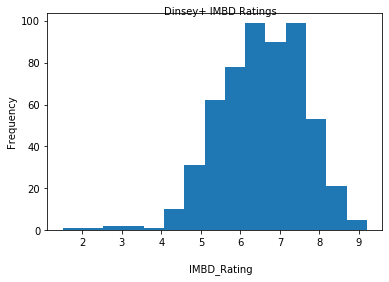

In [146]:
disney_films_df_best['Rating'] = disney_films_df_best['Rating'].replace(['N/A'], np.nan)
disney_films_df_best['Rating'] = disney_films_df_best['Rating'].astype(float)
ax = disney_films_df_best.Rating.plot.hist(bins=15)
ax.text(5.5, -20, 'IMBD_Rating', ha='center')

ax.text(5.5, 103, 'Dinsey+ IMBD Ratings', ha='center')

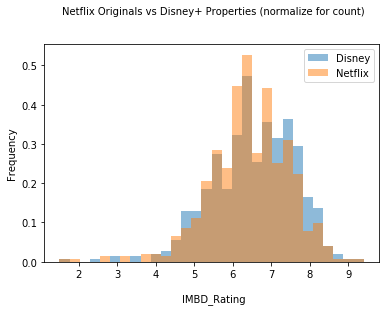

In [147]:
from matplotlib import pyplot
import numpy
new_df = disney_films_df_best.merge(netflix_ratings_df, how="outer", on = "Title")
normalized_ax = new_df.plot.hist(bins=30, alpha=0.5, density=True)
normalized_ax.text(5.5, -.10, 'IMBD_Rating', ha='center')
normalized_ax.text(5.5, .63, 'Netflix Originals vs Disney+ Properties (normalize for count)', ha='center')
normalized_ax.legend(["Disney", "Netflix"]);

The above histogram shows a distribution of Disney+ media content ratings vs Netflix orginal movie ratings. I think many may look at this graph and view Disney's lead as insignificant, but I disagree. This is a trend over hundreds of media pieces, and each rating represents many peoples votes. Perhaps later on in the project I will elaborate on the significance of this, or weigh the ratings by the number of votes a movie has on IMDB.